In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Load Data

In [3]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
dataset_path = "C:/Users/win10/Code/damage-prediction/training/dataset"

dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)
len(dataset)

2300

In [47]:
class_names = dataset.classes
class_names

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [6]:
num_classes = len(dataset.classes)
num_classes

6

In [7]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size

train_size, val_size

(1725, 575)

In [8]:
# Splitting the dataset

from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [10]:
for images, labels in train_loader:
    print(images.shape) # will output color channels as well - RGB
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [11]:
labels[0]

tensor(0)

In [12]:
images[0].shape

torch.Size([3, 224, 224])

In [13]:
images[0].permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.5528543].


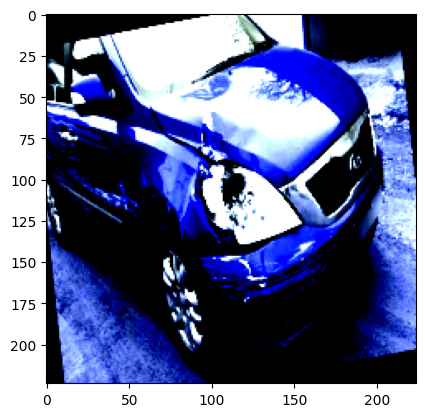

In [14]:
plt.imshow(images[0].permute(1,2,0))
plt.show()

### Model 1: CNN

In [15]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),  # (16, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28)
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.network(x)
        return x

In [16]:
# Instantiate the model, loss function and optimizer

model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            if (batch_num+1) % 10 == 0:
                print(f'Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}')

            running_loss += loss.item()*images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}')

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
            print(f'*** Validation Accuracy: {100*correct/total:.2f}% ***')

    end = time.time()
    print(f'Execution Time: {end - start} seconds')

    return all_labels, all_predictions

In [18]:
all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.81
Batch: 20, Epoch: 1, Loss: 1.80
Batch: 30, Epoch: 1, Loss: 1.80
Batch: 40, Epoch: 1, Loss: 1.78
Batch: 50, Epoch: 1, Loss: 1.78
Epoch [1/10], Avg Loss: 2.0565
*** Validation Accuracy: 20.87% ***
Batch: 10, Epoch: 2, Loss: 1.80
Batch: 20, Epoch: 2, Loss: 1.78
Batch: 30, Epoch: 2, Loss: 1.73
Batch: 40, Epoch: 2, Loss: 1.75
Batch: 50, Epoch: 2, Loss: 1.76
Epoch [2/10], Avg Loss: 1.7683
*** Validation Accuracy: 20.87% ***
Batch: 10, Epoch: 3, Loss: 1.84
Batch: 20, Epoch: 3, Loss: 1.67
Batch: 30, Epoch: 3, Loss: 1.91
Batch: 40, Epoch: 3, Loss: 1.90
Batch: 50, Epoch: 3, Loss: 1.64
Epoch [3/10], Avg Loss: 1.7814
*** Validation Accuracy: 22.61% ***
Batch: 10, Epoch: 4, Loss: 1.74
Batch: 20, Epoch: 4, Loss: 1.73
Batch: 30, Epoch: 4, Loss: 1.84
Batch: 40, Epoch: 4, Loss: 1.81
Batch: 50, Epoch: 4, Loss: 1.76
Epoch [4/10], Avg Loss: 1.7674
*** Validation Accuracy: 20.87% ***
Batch: 10, Epoch: 5, Loss: 1.76
Batch: 20, Epoch: 5, Loss: 1.74
Batch: 30, Epoch: 5, Loss: 1

### Model 2: CNN With Regularization

In [19]:
class CarClassifierCNNRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),  # (16, 224, 224)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28)
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.network(x)
        return x

In [20]:
model = CarClassifierCNNRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 38.64
Batch: 20, Epoch: 1, Loss: 74.90
Batch: 30, Epoch: 1, Loss: 78.02
Batch: 40, Epoch: 1, Loss: 18.34
Batch: 50, Epoch: 1, Loss: 13.57
Epoch [1/10], Avg Loss: 49.1133
*** Validation Accuracy: 24.52% ***
Batch: 10, Epoch: 2, Loss: 9.74
Batch: 20, Epoch: 2, Loss: 4.32
Batch: 30, Epoch: 2, Loss: 1.74
Batch: 40, Epoch: 2, Loss: 1.79
Batch: 50, Epoch: 2, Loss: 1.79
Epoch [2/10], Avg Loss: 4.0156
*** Validation Accuracy: 15.65% ***
Batch: 10, Epoch: 3, Loss: 1.78
Batch: 20, Epoch: 3, Loss: 1.78
Batch: 30, Epoch: 3, Loss: 1.72
Batch: 40, Epoch: 3, Loss: 1.77
Batch: 50, Epoch: 3, Loss: 1.78
Epoch [3/10], Avg Loss: 1.7947
*** Validation Accuracy: 15.48% ***
Batch: 10, Epoch: 4, Loss: 1.80
Batch: 20, Epoch: 4, Loss: 1.77
Batch: 30, Epoch: 4, Loss: 1.78
Batch: 40, Epoch: 4, Loss: 1.73
Batch: 50, Epoch: 4, Loss: 1.70
Epoch [4/10], Avg Loss: 1.8262
*** Validation Accuracy: 19.48% ***
Batch: 10, Epoch: 5, Loss: 1.78
Batch: 20, Epoch: 5, Loss: 1.72
Batch: 30, Epoch: 5, L

([np.int64(1),
  np.int64(3),
  np.int64(2),
  np.int64(1),
  np.int64(2),
  np.int64(1),
  np.int64(5),
  np.int64(0),
  np.int64(2),
  np.int64(4),
  np.int64(1),
  np.int64(3),
  np.int64(1),
  np.int64(5),
  np.int64(3),
  np.int64(4),
  np.int64(2),
  np.int64(0),
  np.int64(2),
  np.int64(2),
  np.int64(5),
  np.int64(2),
  np.int64(3),
  np.int64(3),
  np.int64(4),
  np.int64(3),
  np.int64(5),
  np.int64(4),
  np.int64(2),
  np.int64(2),
  np.int64(5),
  np.int64(5),
  np.int64(1),
  np.int64(1),
  np.int64(3),
  np.int64(3),
  np.int64(0),
  np.int64(5),
  np.int64(3),
  np.int64(2),
  np.int64(1),
  np.int64(5),
  np.int64(2),
  np.int64(2),
  np.int64(1),
  np.int64(2),
  np.int64(0),
  np.int64(5),
  np.int64(5),
  np.int64(2),
  np.int64(4),
  np.int64(5),
  np.int64(3),
  np.int64(3),
  np.int64(1),
  np.int64(0),
  np.int64(5),
  np.int64(4),
  np.int64(1),
  np.int64(2),
  np.int64(4),
  np.int64(2),
  np.int64(0),
  np.int64(1),
  np.int64(4),
  np.int64(2),
  np.int64

### Model 3: Transfer Learning with EfficientNet

In [21]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')

        for param in self.model.parameters():  
            param.requires_grad = False   # Not requires gradient computation. Freezing all the layers
            
        in_features = self.model.classifier[1].in_features

        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [22]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.72
Batch: 20, Epoch: 1, Loss: 1.43
Batch: 30, Epoch: 1, Loss: 1.40
Batch: 40, Epoch: 1, Loss: 1.51
Batch: 50, Epoch: 1, Loss: 1.48
Epoch [1/10], Avg Loss: 1.4970
*** Validation Accuracy: 54.61% ***
Batch: 10, Epoch: 2, Loss: 1.31
Batch: 20, Epoch: 2, Loss: 2.31
Batch: 30, Epoch: 2, Loss: 2.24
Batch: 40, Epoch: 2, Loss: 1.89
Batch: 50, Epoch: 2, Loss: 2.03
Epoch [2/10], Avg Loss: 1.9906
*** Validation Accuracy: 50.96% ***
Batch: 10, Epoch: 3, Loss: 2.10
Batch: 20, Epoch: 3, Loss: 3.40
Batch: 30, Epoch: 3, Loss: 3.58
Batch: 40, Epoch: 3, Loss: 4.44
Batch: 50, Epoch: 3, Loss: 4.79
Epoch [3/10], Avg Loss: 3.4825
*** Validation Accuracy: 50.26% ***
Batch: 10, Epoch: 4, Loss: 3.99
Batch: 20, Epoch: 4, Loss: 3.13
Batch: 30, Epoch: 4, Loss: 1.98
Batch: 40, Epoch: 4, Loss: 3.11
Batch: 50, Epoch: 4, Loss: 4.63
Epoch [4/10], Avg Loss: 3.5660
*** Validation Accuracy: 39.48% ***
Batch: 10, Epoch: 5, Loss: 8.72
Batch: 20, Epoch: 5, Loss: 6.67
Batch: 30, Epoch: 5, Loss: 8

([np.int64(1),
  np.int64(3),
  np.int64(2),
  np.int64(0),
  np.int64(5),
  np.int64(4),
  np.int64(5),
  np.int64(0),
  np.int64(3),
  np.int64(0),
  np.int64(1),
  np.int64(5),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(3),
  np.int64(3),
  np.int64(0),
  np.int64(3),
  np.int64(3),
  np.int64(5),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(3),
  np.int64(2),
  np.int64(3),
  np.int64(0),
  np.int64(5),
  np.int64(3),
  np.int64(1),
  np.int64(0),
  np.int64(3),
  np.int64(4),
  np.int64(1),
  np.int64(0),
  np.int64(3),
  np.int64(4),
  np.int64(2),
  np.int64(2),
  np.int64(4),
  np.int64(2),
  np.int64(1),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64(0),
  np.int64(4),
  np.int64(1),
  np.int64(2),
  np.int64(4),
  np.int64(2),
  np.int64(0),
  np.int64(5),
  np.int64(2),
  np.int64(1),
  np.int64(2),
  np.int64(0),
  np.int64(5),
  np.int64(1),
  np.int64(1),
  np.int64(4),
  np.int64(1),
  np.int64(0),
  np.int64

### Model 4: Transfer Learning with ResNet

In [36]:
# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')

        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():  
            param.requires_grad = False   # Not requires gradient computation. Freezing all the layers

        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True
        
        # Replace the final fully connecter layer
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [37]:
model = CarClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.05
Batch: 20, Epoch: 1, Loss: 0.99
Batch: 30, Epoch: 1, Loss: 0.94
Batch: 40, Epoch: 1, Loss: 0.91
Batch: 50, Epoch: 1, Loss: 0.79
Epoch [1/10], Avg Loss: 1.1687
*** Validation Accuracy: 38.43% ***
Batch: 10, Epoch: 2, Loss: 0.59
Batch: 20, Epoch: 2, Loss: 1.14
Batch: 30, Epoch: 2, Loss: 0.95
Batch: 40, Epoch: 2, Loss: 0.69
Batch: 50, Epoch: 2, Loss: 1.23
Epoch [2/10], Avg Loss: 0.9370
*** Validation Accuracy: 52.00% ***
Batch: 10, Epoch: 3, Loss: 0.96
Batch: 20, Epoch: 3, Loss: 0.93
Batch: 30, Epoch: 3, Loss: 0.82
Batch: 40, Epoch: 3, Loss: 0.93
Batch: 50, Epoch: 3, Loss: 0.64
Epoch [3/10], Avg Loss: 0.8717
*** Validation Accuracy: 69.91% ***
Batch: 10, Epoch: 4, Loss: 0.77
Batch: 20, Epoch: 4, Loss: 1.06
Batch: 30, Epoch: 4, Loss: 1.16
Batch: 40, Epoch: 4, Loss: 0.86
Batch: 50, Epoch: 4, Loss: 0.74
Epoch [4/10], Avg Loss: 0.8687
*** Validation Accuracy: 68.17% ***
Batch: 10, Epoch: 5, Loss: 0.84
Batch: 20, Epoch: 5, Loss: 0.66
Batch: 30, Epoch: 5, Loss: 1

### Model Training & Hyperparameter Tuning

In [25]:
# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')

        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():  
            param.requires_grad = False   # Not requires gradient computation. Freezing all the layers

        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True
        
        # Replace the final fully connecter layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [26]:
# Define the objective function for Optuna
def objective(trial):
    # Suggest values for the hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.7)
    
    # Load the model
    model = CarClassifierResNet(num_classes=num_classes, dropout_rate=dropout_rate).to(device)
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    
    # Training loop (using fewer epochs for faster hyperparameter tuning)
    epochs = 3
    start = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Validation loop
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        
        # Report intermediate result to Optuna
        trial.report(accuracy, epoch)
        
        # Handle pruning (if applicable)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    end = time.time()
    print(f"Execution time: {end - start} seconds")
    
    return accuracy

In [27]:
# Create the study and optimize
import optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2025-12-30 17:37:52,271] A new study created in memory with name: no-name-4fe912a9-6f58-4f7a-88bd-2929a4df369c
[I 2025-12-30 17:41:02,893] Trial 0 finished with value: 76.52173913043478 and parameters: {'lr': 0.007063117474666642, 'dropout_rate': 0.5772934218550859}. Best is trial 0 with value: 76.52173913043478.


Execution time: 190.21833515167236 seconds


[I 2025-12-30 17:44:17,831] Trial 1 finished with value: 56.0 and parameters: {'lr': 1.7638562163960185e-05, 'dropout_rate': 0.3468554472350235}. Best is trial 0 with value: 76.52173913043478.


Execution time: 194.593275308609 seconds


[I 2025-12-30 17:47:32,834] Trial 2 finished with value: 73.3913043478261 and parameters: {'lr': 0.009776671403848587, 'dropout_rate': 0.4795993677882171}. Best is trial 0 with value: 76.52173913043478.


Execution time: 194.65255284309387 seconds


[I 2025-12-30 17:50:46,959] Trial 3 finished with value: 79.30434782608695 and parameters: {'lr': 0.00931369964122243, 'dropout_rate': 0.2697630600158873}. Best is trial 3 with value: 79.30434782608695.


Execution time: 193.78314113616943 seconds


[I 2025-12-30 17:53:56,124] Trial 4 finished with value: 74.6086956521739 and parameters: {'lr': 9.348606841294551e-05, 'dropout_rate': 0.2769166274449261}. Best is trial 3 with value: 79.30434782608695.


Execution time: 188.80122137069702 seconds


[I 2025-12-30 17:54:59,460] Trial 5 pruned. 
[I 2025-12-30 17:58:08,875] Trial 6 finished with value: 78.08695652173913 and parameters: {'lr': 0.00023096545937230617, 'dropout_rate': 0.24819413518324912}. Best is trial 3 with value: 79.30434782608695.


Execution time: 189.07631063461304 seconds


[I 2025-12-30 18:01:17,740] Trial 7 finished with value: 78.26086956521739 and parameters: {'lr': 0.0003211847566325141, 'dropout_rate': 0.6709008154320044}. Best is trial 3 with value: 79.30434782608695.


Execution time: 188.50900316238403 seconds


[I 2025-12-30 18:03:23,983] Trial 8 pruned. 
[I 2025-12-30 18:04:27,120] Trial 9 pruned. 
[I 2025-12-30 18:07:36,702] Trial 10 finished with value: 78.43478260869566 and parameters: {'lr': 0.0014280389652778995, 'dropout_rate': 0.2238339051019269}. Best is trial 3 with value: 79.30434782608695.


Execution time: 189.23209953308105 seconds


[I 2025-12-30 18:08:39,912] Trial 11 pruned. 
[I 2025-12-30 18:11:47,827] Trial 12 finished with value: 77.73913043478261 and parameters: {'lr': 0.0011941175911345965, 'dropout_rate': 0.3141903735985776}. Best is trial 3 with value: 79.30434782608695.


Execution time: 187.5691273212433 seconds


[I 2025-12-30 18:12:51,209] Trial 13 pruned. 
[I 2025-12-30 18:16:00,462] Trial 14 finished with value: 76.69565217391305 and parameters: {'lr': 0.0006282316100388641, 'dropout_rate': 0.2034988169762062}. Best is trial 3 with value: 79.30434782608695.


Execution time: 188.9128074645996 seconds


[I 2025-12-30 18:17:03,553] Trial 15 pruned. 
[I 2025-12-30 18:20:14,024] Trial 16 finished with value: 77.56521739130434 and parameters: {'lr': 0.0007938448559933661, 'dropout_rate': 0.40277662195673053}. Best is trial 3 with value: 79.30434782608695.


Execution time: 190.11586833000183 seconds


[I 2025-12-30 18:21:17,207] Trial 17 pruned. 
[I 2025-12-30 18:22:20,460] Trial 18 pruned. 
[I 2025-12-30 18:23:23,479] Trial 19 pruned. 


### Printing Best Parameters

In [28]:
study.best_params

{'lr': 0.00931369964122243, 'dropout_rate': 0.2697630600158873}

### Trying With The Best Hyperparameters

In [34]:
# Load the pre-trained ResNet model
class CarClassifierResNet1(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.2):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')

        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():  
            param.requires_grad = False   # Not requires gradient computation. Freezing all the layers

        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True
        
        # Replace the final fully connecter layer
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [35]:
model = CarClassifierResNet1(num_classes=num_classes, dropout_rate=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.009)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.21
Batch: 20, Epoch: 1, Loss: 1.35
Batch: 30, Epoch: 1, Loss: 1.74
Batch: 40, Epoch: 1, Loss: 1.51
Batch: 50, Epoch: 1, Loss: 1.87
Epoch [1/10], Avg Loss: 1.9786
*** Validation Accuracy: 39.30% ***
Batch: 10, Epoch: 2, Loss: 1.71
Batch: 20, Epoch: 2, Loss: 2.36
Batch: 30, Epoch: 2, Loss: 6.03
Batch: 40, Epoch: 2, Loss: 2.13
Batch: 50, Epoch: 2, Loss: 2.21
Epoch [2/10], Avg Loss: 4.5142
*** Validation Accuracy: 52.17% ***
Batch: 10, Epoch: 3, Loss: 1.19
Batch: 20, Epoch: 3, Loss: 2.18
Batch: 30, Epoch: 3, Loss: 3.23
Batch: 40, Epoch: 3, Loss: 1.68
Batch: 50, Epoch: 3, Loss: 1.15
Epoch [3/10], Avg Loss: 3.9079
*** Validation Accuracy: 47.65% ***
Batch: 10, Epoch: 4, Loss: 1.67
Batch: 20, Epoch: 4, Loss: 1.63
Batch: 30, Epoch: 4, Loss: 1.62
Batch: 40, Epoch: 4, Loss: 1.91
Batch: 50, Epoch: 4, Loss: 1.73
Epoch [4/10], Avg Loss: 4.0928
*** Validation Accuracy: 34.09% ***
Batch: 10, Epoch: 5, Loss: 1.78
Batch: 20, Epoch: 5, Loss: 1.19
Batch: 30, Epoch: 5, Loss: 1

### Model Evaluation using Confusion Matrix and Classification Report

In [41]:
labels[:10], predictions[:10]

([np.int64(2),
  np.int64(4),
  np.int64(2),
  np.int64(3),
  np.int64(3),
  np.int64(0),
  np.int64(2),
  np.int64(2),
  np.int64(5),
  np.int64(5)],
 [np.int64(2),
  np.int64(4),
  np.int64(2),
  np.int64(4),
  np.int64(3),
  np.int64(0),
  np.int64(2),
  np.int64(2),
  np.int64(4),
  np.int64(5)])

In [44]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.69      0.78       130
           1       0.65      0.57      0.61        89
           2       0.76      0.97      0.85       120
           3       0.75      0.65      0.70        81
           4       0.54      0.63      0.58        71
           5       0.70      0.74      0.72        84

    accuracy                           0.73       575
   macro avg       0.71      0.71      0.71       575
weighted avg       0.73      0.73      0.72       575



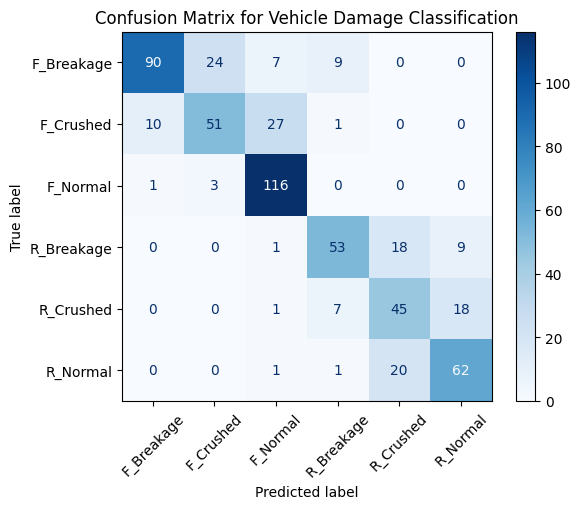

In [48]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix for Vehicle Damage Classification')
plt.show()

### Saving the Model

In [49]:
torch.save(model.state_dict(), 'saved_model.pth')